<a href="https://colab.research.google.com/github/jeevaniitp/Automotive_Issue_Summarization_RAG/blob/main/Automotive_Issue_Summarizer_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

This notebook is an implementation of RAG (Retrieval Augmented Generation) for Automotive Issue Summarization task.


*   Dataset: NHTSA Recalls (https://www.nhtsa.gov/nhtsa-datasets-and-apis)
*   Embeddings: (https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2)
*   LLM Model: (unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit)

Justification for choice:
*   all-MiniLM-L12-v2 is a small model (good efficiency) and has good performance in semantic search tasks
*   I have used Llama 3.1 8B Instrut and quantized model, which is fine tuned to follow instructions given in prompt, and is a quantized model which consumes less resources and has fast inference (considering the compute resource on Colab environment).

RAG Agent Data Flow diagram

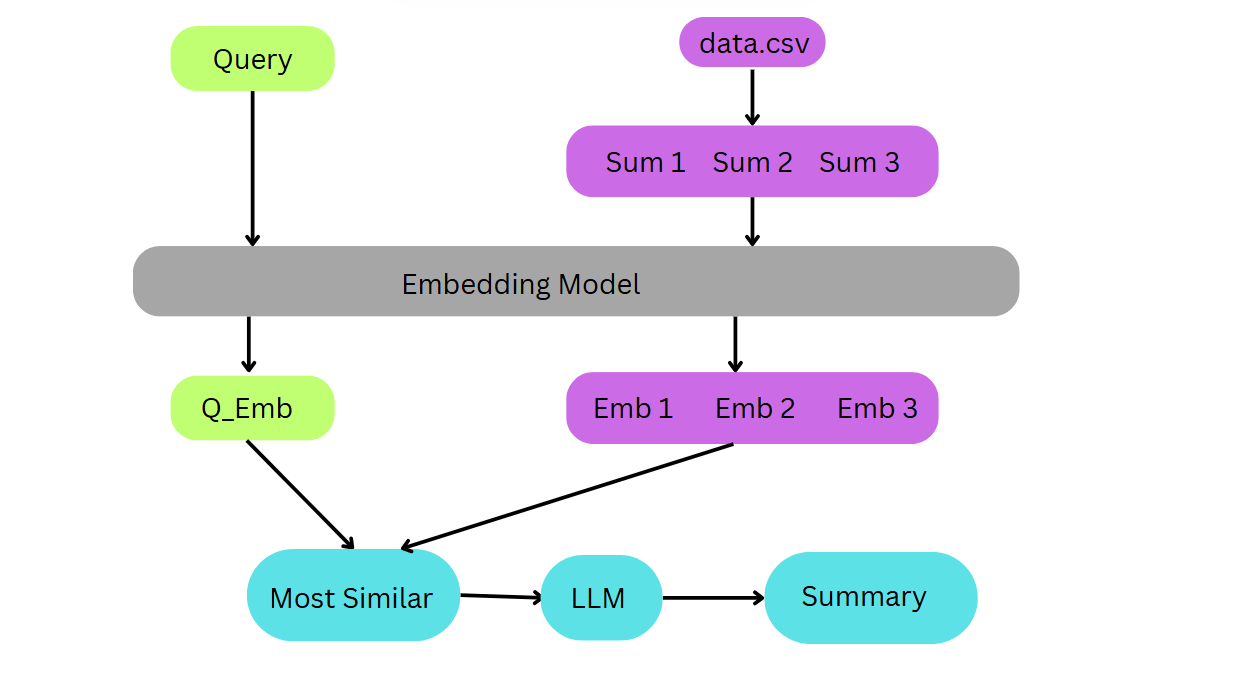

## Data extraction and cleaning

In [22]:
!wget https://static.nhtsa.gov/odi/ffdd/rcl/FLAT_RCL.zip

--2024-12-20 17:03:02--  https://static.nhtsa.gov/odi/ffdd/rcl/FLAT_RCL.zip
Resolving static.nhtsa.gov (static.nhtsa.gov)... 23.198.108.188, 2600:1409:12:393::27ea, 2600:1409:12:3a0::27ea
Connecting to static.nhtsa.gov (static.nhtsa.gov)|23.198.108.188|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14379867 (14M) [application/x-zip-compressed]
Saving to: ‘FLAT_RCL.zip.1’

FLAT_RCL.zip.1      100%[===================>]  13.71M  --.-KB/s    in 0.1s    

2024-12-20 17:03:02 (120 MB/s) - ‘FLAT_RCL.zip.1’ saved [14379867/14379867]



In [23]:
!unzip FLAT_RCL.zip

Archive:  FLAT_RCL.zip
replace FLAT_RCL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FLAT_RCL.txt            


In [24]:
import pandas as pd

In [25]:
def load_flat_rcl_as_list(file_path="/content/FLAT_RCL.txt"):
    """Loads the FLAT_RCL text file as a list, handles parsing errors gracefully.
    Splits by tabs "\t" and returns a list of lists representing the data, where each inner list is a row.
        Returns an empty list if the file does not exist or if an error occurs during processing.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            lines = file.readlines()
            data = [line.strip().split('\t') for line in lines if line.strip()]
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return []
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")
        return []

- Initially I tried using other ways, was getting into many errors due to inconsistancy in the data.
- Some lines in raw data have more columns or entires than other lines

- Filtering relevant columns and converting to csv.
- Filtering for FORD and TOYOTA make

In [26]:
flat_rcl_data = load_flat_rcl_as_list()

if flat_rcl_data:
    print(f"Number of records loaded: {len(flat_rcl_data)}")


final_list = [None] * len(flat_rcl_data)

for j, line in enumerate(flat_rcl_data):
    """
        indices for relevant_list are taken from the last page of the document in the link:
        https://static.nhtsa.gov/odi/ffdd/rcl/Import_Instructions_Recalls.pdf

        Index   Column
        0       RECORD_ID
        2       MAKETXT
        3       MODELTXT
        4       YEARTXT
        19      DESC_DEFECT
        20      CONEQUENCE_DEFECT
        21      CORRECTIVE_ACTION

    """

    relevant_list = [flat_rcl_data[j][i] for i in [0, 2, 3, 4, 19, 20, 21]]
    try:
        final_list[j] = relevant_list[:-3] + [" --- ".join(relevant_list[-3:])]
    except:
        print(j)

if final_list:
    print("First few lines of final_list:")
    for i in range(min(5, len(final_list))):
      print(final_list[i])

# Assign column names
column_names = ['id', 'make', 'model', 'year', 'summary']
df = pd.DataFrame(final_list, columns=column_names)

# Filter for Ford and Toyota
filtered_df = df[df['make'].isin(['FORD', 'TOYOTA'])]


Number of records loaded: 291347
First few lines of final_list:
['1', 'FORD', 'FOCUS', '2000', 'CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MISROUTED BATTERY CABLES COULD LEAD TO CABLE INSULATION DAMAGE. --- THIS, IN TURN, COULD CAUSE THE BATTERY CABLES TO SHORT RESULTING IN HEAT DAMAGE TO THE CABLES.  BESIDES HEAT DAMAGE, THE "CHECK ENGINE" LIGHT MAY ILLUMINATE, THE VEHICLE MAY FAIL TO START, OR SMOKE, MELTING, OR FIRE COULD ALSO OCCUR. --- DEALERS WILL INSPECT THE BATTERY CABLES FOR THE CONDITION OF THE CABLE INSULATION AND PROPER TIGHTENING OF THE TERMINAL ENDS.  AS NECESSARY, CABLES WILL BE REROUTED, RETAINING CLIPS INSTALLED, AND DAMAGED BATTERY CABLES REPLACED.   OWNER NOTIFICATION BEGAN FEBRUARY 10, 2003.   OWNERS WHO DO NOT RECEIVE THE FREE REMEDY  WITHIN A REASONABLE TIME SHOULD CONTACT FORD AT 1-866-436-7332.']
['2', 'FORD', 'FOCUS', '2001', 'CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MIS

In [27]:
df = filtered_df.drop('id', axis=1)

In [28]:
rows_before = len(df)


df = df.drop_duplicates()


rows_after = len(df)

print(f"Number of rows before removing duplicates: {rows_before}")
print(f"Number of rows after removing duplicates: {rows_after}")


Number of rows before removing duplicates: 17135
Number of rows after removing duplicates: 9630


Nearly half of them are dulicate

In [29]:

# Count the occurrences of 'FORD' and 'TOYOTA' in the 'make' column
ford_count = df[df['make'] == 'FORD'].shape[0]
toyota_count = df[df['make'] == 'TOYOTA'].shape[0]

print(f"Number of Ford rows: {ford_count}")
print(f"Number of Toyota rows: {toyota_count}")

Number of Ford rows: 7291
Number of Toyota rows: 2339


In [30]:
df.head()

,make,model,year,summary
0,FORD,FOCUS,2000,CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...
1,FORD,FOCUS,2001,CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC...
148,FORD,CROWN VICTORIA,2002,"ON CERTAIN NATURAL GAS MODEL VEHICLES, A T-FIT..."
300,FORD,NAVIGATOR,2000,CERTAIN 4X2 SPORT UTILITY VEHICLES FAIL TO COM...
301,FORD,EXPEDITION,2000,CERTAIN 4X2 SPORT UTILITY VEHICLES FAIL TO COM...


In [31]:
# No. of unique models for FORD
ford_models = df[df['make'] == 'FORD']['model'].unique()
print("FORD Models:", len(ford_models))

print("\n")

# No. of unique models for TOYOTA
toyota_models = df[df['make'] == 'TOYOTA']['model'].unique()
print("TOYOTA Models:", len(toyota_models))

FORD Models: 313


TOYOTA Models: 79


In [32]:
df.to_csv('data.csv', index=False)

print("data.csv .... SAVED")

data.csv .... SAVED


####Sampling first 100 rows for testing

In [33]:
# df = df.head(100)
# print(len(df))

In [34]:
# df.to_csv('data.csv', index=False)

## Model

In [1]:
%%capture

!pip install unsloth
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from typing import Dict, List, Tuple
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline


from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


Load Model

In [3]:
max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2024.12.8: Fast Llama patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaExtendedRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): L

####Method 1:

This method combines make, model, year and issue from the user input and computes query_embedding and computes summary_embedding on combined columns in a particular row of data frame.

In [58]:
class AutoIssueAgent:
    def __init__(self, data_path: str, embedding_model: str = 'all-MiniLM-L6-v2'):
        """
        Initializes the automotive issue summarization agent.

        """

        # Load and preprocess the dataset
        self.df = pd.read_csv(data_path)
        self.df = self.df.fillna('')

        # Initialize the embedding model
        self.embedding_model = SentenceTransformer(embedding_model)


        self.df['combined_text'] = self.df.apply(
            lambda row: f"Make: {row['make']} Model: {row['model']} Year: {row['year']} Summary: {row['summary']}",
            axis=1
        )

        # print(len(self.df.columns))

        # Compute embeddings using combined text
        self.document_embeddings = self.embedding_model.encode(
            self.df['combined_text'].tolist(),
            show_progress_bar=False,
            convert_to_tensor=True
        )


        self.model = model
        self.tokenizer = tokenizer

        # Create summarization pipeline
        self.summarizer = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            max_new_tokens=512,
            temperature=0.7
        )


    def retrieve_relevant_documents(self, query: Dict, top_k: int = 3) -> List[Tuple[float, str]]:
        """
        Retrieve the most relevant documents based on the input query.

            top_k: Number of documents to retrieve, default is 3

        Returns list of tuples containing (similarity_score, document_text)
        """
        # Create query string
        query_text = f"Make: {query['make']} Model: {query['model']} Year: {query['year']} Issue: {query['issue']}"

        # Encode query
        query_embedding = self.embedding_model.encode(query_text, convert_to_tensor=True)

        # Calculate similarities
        similarities = cosine_similarity(
            query_embedding.cpu().numpy().reshape(1, -1),
            self.document_embeddings.cpu().numpy()
        )[0]

        # Get top-k most similar documents
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        return [(similarities[i], self.df.iloc[i]['combined_text']) for i in top_indices]

    def generate_summary(self, relevant_docs: List[Tuple[float, str]], query: Dict) -> str:


        # Create prompt
        context = "\n".join([f"Document {i+1} (similarity: {score:.3f}):\n{doc}"
                           for i, (score, doc) in enumerate(relevant_docs)])


        prompt = f"""Based on the following documents about automotive issues, provide a concise summary
        for a Make: {query['make']} Model: {query['model']} Year: {query['year']} regarding the issue: {query['issue']}.

        Generate only summary.
        Do not generate follow up and final answer or Note or Disclaimer.
        Do not repeate yourself in generated text.
        Mention if you have found any miss match in make model or year

        Reference Documents:
        {context}

        Summary:"""



        # Generate summary
        response = self.summarizer(prompt)[0]['generated_text']

        # Extract the summary part (after "Summary:")
        summary = response.split("Summary:")[-1].strip()

        return summary

    def process_query(self, query: Dict) -> Dict:
        """
        Process a query and return relevant documents and summary.

        query: Dictionary containing make, model, year, and issue

        Returns a dictionary containing retrieved documents and final summary
        """

        # Retrieve relevant documents
        relevant_docs = self.retrieve_relevant_documents(query)

        # Generate summary
        summary = self.generate_summary(relevant_docs, query)

        return {
            'retrieved_documents': relevant_docs,
            'summary': summary
        }



In [60]:
# Initialize agent
agent = AutoIssueAgent("data.csv")

5


In [61]:

if __name__ == "__main__":

    query = {
        'make': 'ford',
        'model': 'focus',
        'year': '2001',
        'issue': 'broken attachments and misrouted battery cables'
    }

    # Process query
    result = agent.process_query(query)

    # Print results
    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.725):
Make: FORD Model: FOCUS Year: 2001 Summary: CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MISROUTED BATTERY CABLES COULD LEAD TO CABLE INSULATION DAMAGE. --- THIS, IN TURN, COULD CAUSE THE BATTERY CABLES TO SHORT RESULTING IN HEAT DAMAGE TO THE CABLES.  BESIDES HEAT DAMAGE, THE "CHECK ENGINE" LIGHT MAY ILLUMINATE, THE VEHICLE MAY FAIL TO START, OR SMOKE, MELTING, OR FIRE COULD ALSO OCCUR. --- DEALERS WILL INSPECT THE BATTERY CABLES FOR THE CONDITION OF THE CABLE INSULATION AND PROPER TIGHTENING OF THE TERMINAL ENDS.  AS NECESSARY, CABLES WILL BE REROUTED, RETAINING CLIPS INSTALLED, AND DAMAGED BATTERY CABLES REPLACED.   OWNER NOTIFICATION BEGAN FEBRUARY 10, 2003.   OWNERS WHO DO NOT RECEIVE THE FREE REMEDY  WITHIN A REASONABLE TIME SHOULD CONTACT FORD AT 1-866-436-7332.

Document 2 (Similarity: 0.700):
Make: FORD Model: FOCUS Year: 2000 Summary: CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETE

##### More examples

Actual year is 2001 and 2002

In [62]:
if __name__ == "__main__":


    query = {
        'make': 'ford',
        'model': 'focus',
        'year': '2003',
        'issue': 'broken attachments and misrouted battery cables'
    }

    # Process query
    result = agent.process_query(query)

    # Print results
    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.717):
Make: FORD Model: FOCUS Year: 2001 Summary: CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MISROUTED BATTERY CABLES COULD LEAD TO CABLE INSULATION DAMAGE. --- THIS, IN TURN, COULD CAUSE THE BATTERY CABLES TO SHORT RESULTING IN HEAT DAMAGE TO THE CABLES.  BESIDES HEAT DAMAGE, THE "CHECK ENGINE" LIGHT MAY ILLUMINATE, THE VEHICLE MAY FAIL TO START, OR SMOKE, MELTING, OR FIRE COULD ALSO OCCUR. --- DEALERS WILL INSPECT THE BATTERY CABLES FOR THE CONDITION OF THE CABLE INSULATION AND PROPER TIGHTENING OF THE TERMINAL ENDS.  AS NECESSARY, CABLES WILL BE REROUTED, RETAINING CLIPS INSTALLED, AND DAMAGED BATTERY CABLES REPLACED.   OWNER NOTIFICATION BEGAN FEBRUARY 10, 2003.   OWNERS WHO DO NOT RECEIVE THE FREE REMEDY  WITHIN A REASONABLE TIME SHOULD CONTACT FORD AT 1-866-436-7332.

Document 2 (Similarity: 0.705):
Make: FORD Model: FOCUS Year: 2000 Summary: CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETE

Above generated with lower similarity score than previous example

Giving wrong model

In [63]:
if __name__ == "__main__":


    query = {
        'make': 'ford',
        'model': 'expedition',
        'year': '2001',
        'issue': 'broken attachments and misrouted battery cables'
    }

    # Process query
    result = agent.process_query(query)

    # Print results
    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.624):
Make: FORD Model: EXPEDITION Year: 1999 Summary: VEHICLE DESCRIPTION:  SPORT UTILITY VEHICLES.  THE FUEL LINE ASSEMBLIES MAY HAVE BEEN DAMAGED BY THE SUPPLIER DURING MANUFACTURING, ALLOWING LEAKAGE. --- FUEL LEAKAGE IN THE PRESENCE OF AN IGNITION SOURCE CAN RESULT IN A FIRE. --- DEALERS WILL INSPECT THESE VEHICLES AND, IF NECESSARY, REPLACE THE FRONT AND REAR FUEL LINE ASSEMBLIES.

Document 2 (Similarity: 0.618):
Make: FORD Model: FOCUS Year: 2001 Summary: CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MISROUTED BATTERY CABLES COULD LEAD TO CABLE INSULATION DAMAGE. --- THIS, IN TURN, COULD CAUSE THE BATTERY CABLES TO SHORT RESULTING IN HEAT DAMAGE TO THE CABLES.  BESIDES HEAT DAMAGE, THE "CHECK ENGINE" LIGHT MAY ILLUMINATE, THE VEHICLE MAY FAIL TO START, OR SMOKE, MELTING, OR FIRE COULD ALSO OCCUR. --- DEALERS WILL INSPECT THE BATTERY CABLES FOR THE CONDITION OF THE CABLE INSULATION AND PROP

Correctly identifies and summarizes

####Method 2:

 This method is an implementation which filter rows based on vehicle details (make, model and year) first and then perform similarity search on the filtered subset, with precomputed embeddings.

In [77]:
class AutoIssueAgent:
    def __init__(self, data_path: str, embedding_model: str = 'all-MiniLM-L6-v2'):
        """
        Initializes the automotive issue summarization agent.

        """

        # Load and preprocess the dataset
        self.df = pd.read_csv(data_path)
        self.df = self.df.fillna('')

        # Convert make, model, year to lowercase for case-insensitive matching
        self.df['make'] = self.df['make'].str.lower()
        self.df['model'] = self.df['model'].str.lower()
        self.df['year'] = self.df['year'].astype(str)

        # Initialize the embedding model
        self.embedding_model = SentenceTransformer(embedding_model)

        # Create dictionary to store precomputed embeddings for each unique combination
        self.precomputed_embeddings = {}
        self._precompute_embeddings()


        self.model = model
        self.tokenizer = tokenizer

        # Create summarization pipeline
        self.summarizer = pipeline(
            "text-generation",
            model=self.model,
            tokenizer=self.tokenizer,
            max_new_tokens=512,
            temperature=0.7
        )

    def _precompute_embeddings(self):
        """
        Precomputes embeddings for each unique make-model-year combination.
        Stores them in a dictionary for quick access.
        """
        # Group by make, model, year
        groups = self.df.groupby(['make', 'model', 'year'])

        for (make, model, year), group in groups:
            key = (make, model, year)
            summaries = group['summary'].tolist()

            # Compute embeddings for all summaries in this group
            embeddings = self.embedding_model.encode(
                summaries,
                show_progress_bar=False,
                convert_to_tensor=True
            )

            # Store embeddings and corresponding summaries
            self.precomputed_embeddings[key] = {
                'embeddings': embeddings,
                'summaries': summaries
            }

    def retrieve_relevant_documents(self, query: Dict, top_k: int = 3) -> List[Tuple[float, str]]:
        """
        Retrieve the most relevant documents based on the input query.
        First filters by make, model, year, then performs similarity search.

        Returns a list of tuples containing (similarity_score, document_text)
        """
        # Normalize query values
        make = query['make'].lower()
        model = query['model'].lower()
        year = str(query['year'])
        key = (make, model, year)

        # Check if we have documents for this vehicle
        if key not in self.precomputed_embeddings:
            return []

        # Get precomputed embeddings and summaries for this vehicle
        vehicle_data = self.precomputed_embeddings[key]
        embeddings = vehicle_data['embeddings']
        summaries = vehicle_data['summaries']

        # If no documents found for this vehicle
        if len(summaries) == 0:
            return []

        # Encode the issue query
        query_embedding = self.embedding_model.encode(query['issue'], convert_to_tensor=True)

        # Calculate similarities with the filtered set of documents
        similarities = cosine_similarity(
            query_embedding.cpu().numpy().reshape(1, -1),
            embeddings.cpu().numpy()
        )[0]

        # Get top-k most similar documents
        top_k = min(top_k, len(similarities))
        top_indices = np.argsort(similarities)[-top_k:][::-1]

        return [(similarities[i], summaries[i]) for i in top_indices]

    def generate_summary(self, relevant_docs: List[Tuple[float, str]], query: Dict) -> str:

        if not relevant_docs:
            return f"No relevant documents found for {query['year']} {query['make']} {query['model']}."

        # Create prompt
        context = "\n".join([f"Document {i+1} (similarity: {score:.3f}):\n{doc}"
                           for i, (score, doc) in enumerate(relevant_docs)])


        prompt = f"""Based on the following documents about automotive issues, provide a concise summary
        for a Make: {query['make']} Model: {query['model']} Year: {query['year']} regarding the issue: {query['issue']}.

        Generate only summary.
        Do not generate follow up and final answer or Note or Disclaimer.
        Do not repeat yourself in generated text.

        Reference Documents:
        {context}

        Summary:"""


        response = self.summarizer(prompt)[0]['generated_text']


        summary = response.split("Summary:")[-1].strip()

        return summary

    def process_query(self, query: Dict) -> Dict:
        """
        Processes a query and return relevant documents and summary.

        """

        relevant_docs = self.retrieve_relevant_documents(query)


        summary = self.generate_summary(relevant_docs, query)

        return {
            'retrieved_documents': relevant_docs,
            'summary': summary
        }



In [78]:
# Initialize agent
agent = AutoIssueAgent("data.csv")

In [79]:

if __name__ == "__main__":

    query = {
        'make': 'ford',
        'model': 'focus',
        'year': '2001',
        'issue': 'broken attachments and misrouted battery cables'
    }


    result = agent.process_query(query)

    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.522):
CERTAIN PASSENGER VEHICLES EQUIPPED WITH ZETEC ENGINES, LOOSE OR BROKEN ATTACHMENTS AND MISROUTED BATTERY CABLES COULD LEAD TO CABLE INSULATION DAMAGE. --- THIS, IN TURN, COULD CAUSE THE BATTERY CABLES TO SHORT RESULTING IN HEAT DAMAGE TO THE CABLES.  BESIDES HEAT DAMAGE, THE "CHECK ENGINE" LIGHT MAY ILLUMINATE, THE VEHICLE MAY FAIL TO START, OR SMOKE, MELTING, OR FIRE COULD ALSO OCCUR. --- DEALERS WILL INSPECT THE BATTERY CABLES FOR THE CONDITION OF THE CABLE INSULATION AND PROPER TIGHTENING OF THE TERMINAL ENDS.  AS NECESSARY, CABLES WILL BE REROUTED, RETAINING CLIPS INSTALLED, AND DAMAGED BATTERY CABLES REPLACED.   OWNER NOTIFICATION BEGAN FEBRUARY 10, 2003.   OWNERS WHO DO NOT RECEIVE THE FREE REMEDY  WITHIN A REASONABLE TIME SHOULD CONTACT FORD AT 1-866-436-7332.

Document 2 (Similarity: 0.234):
PM CERTAIN SEDANS AND WAGONS, THE SEAT BACK RECLINER HANDLE SPRING COULD HAVE BEEN DAMAGED DURING AN IN-PROCESS TEST AND THE OCCUPANT

##### More Examples

Actual year 2001 or 2002

In [70]:

if __name__ == "__main__":

    query = {
        'make': 'ford',
        'model': 'focus',
        'year': '2003',
        'issue': 'broken attachments and misrouted battery cables'
    }


    result = agent.process_query(query)

    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.208):
CERTAIN AFTERMARKET FUEL FILTERS SOLD UNDER THE PUROLATOR BRAND NAME, P/N F65277, SHIPPED FROM JANUARY 16 THROUGH JUNE 2, 2006, FOR USE ON THE ABOVE LISTED PASSENGER VEHICLES.  DUE TO INCORRECT DESIGN, THE QUICK CONNECTORS MAY NOT FULLY SEAT WITH THE TUBE INTERFACE, EVEN THOUGH THE PERSON MAKING THE CONNECTION MAY BELIEVE THAT THE QUICK CONNECTOR IS FULLY ATTACHED.   --- FAILURE OF THIS CONNECTION COULD LEAD TO FUEL SPILLAGE AND, IN THE PRESENCE OF AN IGNITION SOURCE, A FIRE COULD OCCUR. --- UFI WILL NOTIFY OWNERS AND REPLACE THE FILTERS FREE OF CHARGE.  THE RECALL BEGAN ON AUGUST 4, 2006.  OWNERS MAY CONTACT UFI FILTERS USA AT 800-230-5876.

Document 2 (Similarity: 0.189):
RIDE CONTROL, LLC (RIDE CONTROL) IS RECALLING CERTAIN READYMOUNT ASSEMBLIES, P/N 746641MT AND 746646MT, WITH CORRESPONDING AFTERMARKET CUSTOMER PART NUMBERS: GABRIEL G56944 AND GABRIEL G56945, AND PRIVATELY BRANDED PARTSMASTER WITH PART NUMBERS G68944 AND G68945

Very deterministic and less hallucination

Model mis match

In [71]:

if __name__ == "__main__":

    query = {
        'make': 'ford',
        'model': 'expedition',
        'year': '2001',
        'issue': 'broken attachments and misrouted battery cables'
    }


    result = agent.process_query(query)

    print("\nRetrieved Documents:")
    for i, (score, doc) in enumerate(result['retrieved_documents'], 1):
        print(f"\nDocument {i} (Similarity: {score:.3f}):")
        print(doc)

    print("\nGenerated Summary:")
    print(result['summary'])


Retrieved Documents:

Document 1 (Similarity: 0.281):
CERTAIN PICKUP TRUCK, VAN, AND MINI VAN CONVERSIONS EQUIPPED WITH SOUTHERN COMFORT BUILT RUNNING BOARDS THAT CONTAIN CERTAIN COURTESY LIGHTS MANUFACTURED BY AMERICAN TECHNOLOGY COMPONENTS, INC.  THESE UNITS CONTAIN A COURTESY LIGHT OR LIGHTS THAT MIGHT OVERHEAT WHEN THE WIRE HARNESS IS EXPOSED TO EXCESSIVE MOISTURE AND ROAD SALT.   --- THIS OVERHEATING CONDITION CAN CAUSE THE RUNNING BOARD TO MELT OR CAUSE A FIRE.   --- DEALERS WILL REPLACE THE WIRING HARNESS ON THESE RUNNING BOARDS.  OWNER NOTIFICATION BEGAN MARCH 7, 2003.  OWNERS WHO TAKE THEIR VEHICLES TO AN AUTHORIZED DEALER ON AN AGREED UPON SERVICE DATE AND DO NOT RECEIVE THE FREE REMEDY WITHIN A REASONABLE TIME SHOULD CONTACT SOUTHERN COMFORT AT 1-800-745-6096.  

Document 2 (Similarity: 0.208):
CERTAIN AFTERMARKET FUEL FILTERS SOLD UNDER THE PUROLATOR BRAND NAME, P/N F65277, SHIPPED FROM JANUARY 16 THROUGH JUNE 2, 2006, FOR USE ON THE ABOVE LISTED PASSENGER VEHICLES.  DUE T

Again deterministic and less prone to hallucinations